<a href="https://colab.research.google.com/github/Fnriquel/281-Project/blob/main/Efficiennet_Colabversion_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import charset_normalizer
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax, SGD, Adagrad
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from pathlib import Path
from sklearn.cluster import KMeans


In [3]:
source_dir = "/content/drive/MyDrive/W281/Original"
train_dir = "/content/drive/MyDrive/W281/Train_image"
val_dir = "/content/drive/MyDrive/W281/val_image"
test_dir = "/content/drive/MyDrive/W281/Test_image"

In [4]:
import cv2

def img_norm(src_img):
  """ Perform color transfer according to the method described 
  by Zhang C, Xiao X, Li X, Chen YJ, Zhen W, Chang J, Zheng C, Liu Z. 
  White blood cell segmentation by color-space-based k-means clustering. 
  Sensors (Basel). 2014 Sep 1;14(9):16128-47
  
  Parameters:
  -----------
    src_img : array-like
      image to adjust through color transfer
      
    img_template : array-like
      image that would represent a golden standard
  
  Returns:
  --------
    img : array-like
      image array of color-adjusted src_img
  
  """
  verbose=False
  
  # retrieve template image
  img_template = cv2.imread("/content/drive/MyDrive/W281/Original/Benign/WBC-Benign-028.jpg")

  
  #print("temp max:", np.max(img_template),"min:", np.min(img_template))
  #print("src max:", np.max(src_img),"min:", np.min(src_img))
  # 1. Transform the RGB color space of the input image and 
  #    the template image to Lab color space
  #src_lab = cv2.cvtColor(src_img, cv2.COLOR_RGB2LAB)
  src_lab = cv2.cvtColor(src_img.astype(np.uint8), cv2.COLOR_RGB2LAB)
  
  src_lc,src_ac,src_bc = cv2.split(src_lab)
  
  tmp_lab = cv2.cvtColor(img_template, cv2.COLOR_BGR2LAB)
  tmp_lc,tmp_ac,tmp_bc = cv2.split(tmp_lab)
  
  # 2. Compute the mean value and standard deviation of the
  #    input image and the template image in Lab color space
  # 3. Subtract the mean value from all the pixels
  src_lcp = src_lc - np.mean(src_lc)
  src_acp = src_ac - np.mean(src_ac)
  src_bcp = src_bc - np.mean(src_bc)
  #print("source bcp channel", np.max(src_bcp), np.min(src_bcp))
  tmp_lcp = tmp_lc - np.mean(tmp_lc)
  tmp_acp = tmp_ac - np.mean(tmp_ac)
  tmp_bcp = tmp_bc - np.mean(tmp_bc)
  #print("template bcp channel", np.max(tmp_bcp), np.min(tmp_bcp))
  # 4. Scale the pixel points of each color component of the 
  #    synthetic image by factors determined by the ratio of 
  #    respective standard deviations
  sig_src_lc = np.std(src_lc)
  sig_src_ac = np.std(src_ac)
  sig_src_bc = np.std(src_bc)
  
  sig_tmp_lc = np.std(tmp_lc)
  sig_tmp_ac = np.std(tmp_ac)
  sig_tmp_bc = np.std(tmp_bc)
  
  img_lc = src_lcp * (np.divide(sig_tmp_lc,sig_src_lc)) + np.mean(tmp_lc)
  img_ac = src_acp * (np.divide(sig_tmp_ac,sig_src_ac)) + np.mean(tmp_ac)
  img_bc = src_bcp * (np.divide(sig_tmp_bc,sig_src_bc)) + np.mean(tmp_bc)
  
  img = np.stack((img_lc, img_ac, img_bc), axis=-1)
  #print("min im",np.min(img),"max im",np.max(img))
  # clip image
  #img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
  img = np.clip(img, 1, 255)
  img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  img = img.astype(np.float64)
  #img=img/255
  if verbose:
    fig, axs = plt.subplots(1,3,figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(img_template, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0)
    axs[0].title.set_text('Template Image')
    axs[0].axis('off')
    axs[1].imshow(src_img.astype(np.float32)/255.0)
    axs[1].title.set_text('Src Image')
    axs[1].axis('off')
    axs[2].imshow(img/255)
    
    axs[2].title.set_text('Synthetic Image')
    axs[2].axis('off')
    
  return img_to_array(img)
  
def img_seg_lab(img):
  """ Segment nucleus from the blood smear images for later feature
      extraction. Does source image norming through color transfer,
      so make sure that ref_img_path is defined globally for template
      image. This segmentation mostly follows the approach by Acharya and Kumar:
      Acharya, V., Kumar, P. Detection of acute lymphoblastic leukemia using 
      image segmentation and data mining algorithms. 
      Med Biol Eng Comput 57, 1783–1811 (2019). https://doi.org/10.1007/s11517-019-01984-1
      
      Parameters:
      -----------
        path : str
          path to the image file
          
      Returns:
      --------
        img : array-like
          img filtered (blacked out) to segmented nucleus only
    
  """
  verbose=True
  def preprocess_helper(raw_img):
    # apply median blur to reduce image noise
    img = cv2.medianBlur(raw_img, 3)
       
    return img
  
  # load image
  raw_img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR)
  
  # load template
  syn_img = img_norm(raw_img)#im loading the template on the im_norm function
  raw_img_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
  
  img_shape = raw_img.shape
  channel_shape = raw_img.shape[:2]
  
  # preprocess image with histogram equalization
  pre_img = preprocess_helper(syn_img)
  
  # convert to LAB
  lab_img = cv2.cvtColor(pre_img, cv2.COLOR_BGR2LAB)
  lc,ac,bc = cv2.split(lab_img)

  # vectorize pixels keeping a,b channels
  vec = np.stack((ac,bc), axis=-1).reshape(-1,2)
  
  # k-medoids
  km = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec)
  labs = np.unique(km.labels_) 
   
  # pick the darkest cluster
  cl = labs[np.argmax([ np.mean(vec[km.labels_ == lab]) for lab in labs ])]
  
  # create mask for highest intensity cluster
  mask = np.ones(vec.shape[0])
  
  mask[(km.labels_ != cl)] = 0
  mask = mask.reshape(raw_img.shape[:2])
  
  img = raw_img_rgb.copy()
  img[(km.labels_ != cl).reshape(channel_shape),:] = 0
  
  if verbose:
    fig, axs = plt.subplots(1,2,figsize=(5,5))
    axs[0].imshow(raw_img_rgb/255)
    axs[0].axis('off')
    axs[1].imshow(img/255)
    axs[1].axis('off')

    plt.show()
  
  return img_to_array(img)
  


def min_max_intensity_normalization(img):
    img_array = img_to_array(img)
    min_value = np.min(img_array)
    max_value = np.max(img_array)
    normalized_array = (img_array - min_value) / (max_value - min_value)
    return normalized_array

def adaptive_hist_eq(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(image)
    return cl1

## function to do histogram normalization
from skimage import exposure, color

def hist_norm(img):
    img[:,:,0] = exposure.equalize_hist(img[:,:,0])
    img[:,:,1] = exposure.equalize_hist(img[:,:,1])
    img[:,:,2] = exposure.equalize_hist(img[:,:,2])
    return img

##function that gets all the pictures from the directory and apply the adaptive histogram equalization
def get_images_processing(directory, processing='adaptive_histogram_equalization'):
    images=[]
    for dir in os.listdir(directory):
        for dir1 in os.listdir('Original'+'\\'+str(dir)):
            img = cv2.imread(directory+'\\'+dir+'\\'+dir1)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if processing == 'adaptive_histogram_equalization':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = adaptive_hist_eq(img)
            elif processing == 'histogram_normalization':
                img = hist_norm(img)   
            elif processing == 'sharpening':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                img = cv2.filter2D(img, -1, kernel)
            else:
                img = img
            
            images.append(img)
    return images

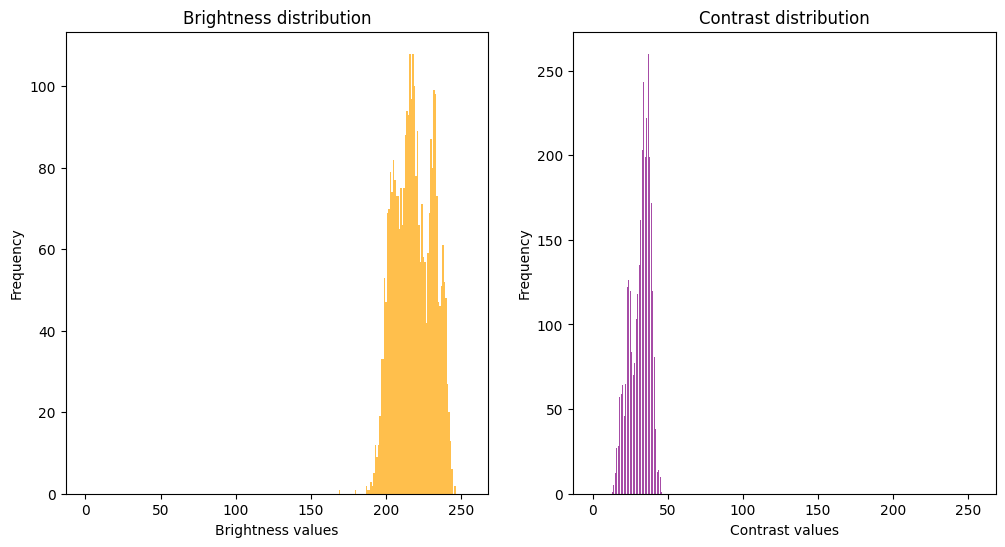

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

main_directory = "/content/drive/MyDrive/W281/Original"
class_folders = os.listdir(main_directory)

def brightness(image):
    return np.mean(image)

def contrast(image):
    return np.std(image)

def update_histogram(hist, values, bins):
    new_hist, _ = np.histogram(values, bins=bins)
    return hist + new_hist

bins = 256
brightness_hist = np.zeros(bins)
contrast_hist = np.zeros(bins)

batch_size = 50
bins_brightness = np.linspace(0, 255, bins + 1)
bins_contrast = np.linspace(0, 255, bins + 1)

for class_folder in class_folders:
    class_directory = os.path.join(main_directory, class_folder)
    image_filenames = os.listdir(class_directory)

    for i in range(0, len(image_filenames), batch_size):
        batch_filenames = image_filenames[i:i+batch_size]
        
        brightness_values = []
        contrast_values = []

        for filename in batch_filenames:
            img_path = os.path.join(class_directory, filename)
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            brightness_values.append(brightness(img_gray))
            contrast_values.append(contrast(img_gray))

        brightness_hist = update_histogram(brightness_hist, brightness_values, bins_brightness)
        contrast_hist = update_histogram(contrast_hist, contrast_values, bins_contrast)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot brightness histogram
ax1.bar(np.arange(bins), brightness_hist, color='orange', alpha=0.7)
ax1.set_title('Brightness distribution')
ax1.set_xlabel('Brightness values')
ax1.set_ylabel('Frequency')

# Plot contrast histogram
ax2.bar(np.arange(bins), contrast_hist, color='purple', alpha=0.7)
ax2.set_title('Contrast distribution')
ax2.set_xlabel('Contrast values')
ax2.set_ylabel('Frequency')

plt.show()



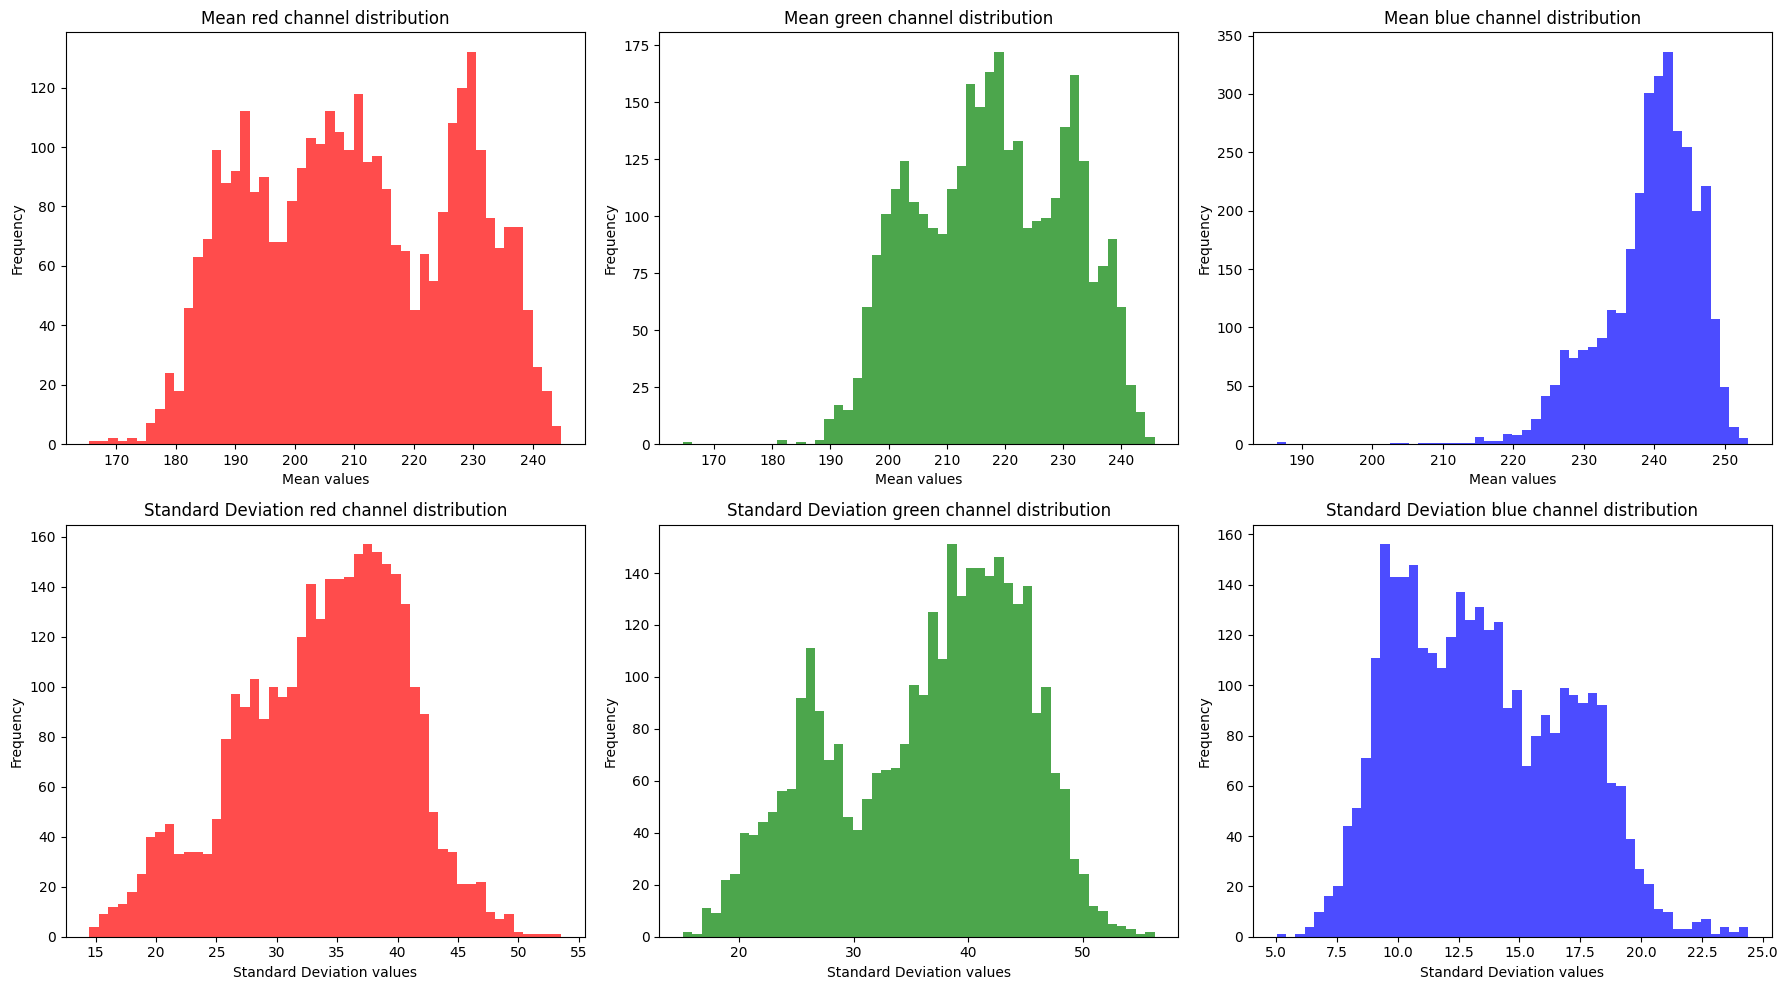

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

main_directory = "/content/drive/MyDrive/W281/Original"
class_folders = os.listdir(main_directory)

means = []
stds = []

batch_size = 50

for class_folder in class_folders:
    class_directory = os.path.join(main_directory, class_folder)
    image_filenames = os.listdir(class_directory)

    for i in range(0, len(image_filenames), batch_size):
        batch_filenames = image_filenames[i:i+batch_size]
        batch_means = []
        batch_stds = []

        for filename in batch_filenames:
            img_path = os.path.join(class_directory, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mean = img_rgb.mean(axis=(0, 1))
            std = img_rgb.std(axis=(0, 1))

            batch_means.append(mean)
            batch_stds.append(std)

        means.extend(batch_means)
        stds.extend(batch_stds)

means = np.array(means)
stds = np.array(stds)

colors = ['red', 'green', 'blue']
bins = 50

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, color in enumerate(colors):
    axs[0, i].hist(means[:, i], bins=bins, color=color, alpha=0.7)
    axs[0, i].set_title(f'Mean {color} channel distribution')
    axs[0, i].set_xlabel('Mean values')
    axs[0, i].set_ylabel('Frequency')

    axs[1, i].hist(stds[:, i], bins=bins, color=color, alpha=0.7)
    axs[1, i].set_title(f'Standard Deviation {color} channel distribution')
    axs[1, i].set_xlabel('Standard Deviation values')
    axs[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Only run the cell bellow to create the 3 folders Train and Test and validate.

In [ ]:
import os
import shutil
import random

# Create train, validation, and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Set the percentage of images to use for training, validation, and testing
train_percentage = 0.6
validation_percentage = 0.2

# Loop through each sub-directory in the source directory
for subdir in os.listdir(source_dir):
    subdir_path = os.path.join(source_dir, subdir)
    
    # Create train, validation, and test sub-directories
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
    
    # Split the images between train, validation, and test sets
    images = os.listdir(subdir_path)
    random.shuffle(images)
    train_split_index = int(train_percentage * len(images))
    validation_split_index = int((train_percentage + validation_percentage) * len(images))
    
    train_images = images[:train_split_index]
    validation_images = images[train_split_index:validation_split_index]
    test_images = images[validation_split_index:]
    
    # Copy the train images to the train directory
    for image in train_images:
        source = os.path.join(subdir_path, image)
        destination = os.path.join(train_dir, subdir, image)
        shutil.copy(source, destination)
    
    # Copy the validation images to the validation directory
    for image in validation_images:
        source = os.path.join(subdir_path, image)
        destination = os.path.join(val_dir, subdir, image)
        shutil.copy(source, destination)

    # Copy the test images to the test directory
    for image in test_images:
        source = os.path.join(subdir_path, image)
        destination = os.path.join(test_dir, subdir, image)
        shutil.copy(source, destination)


In [4]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
img_size = (224, 224)
input_shape = (224,224,3)


# Create a base model from the pre-trained 
#base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet') 
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=input_shape, include_top=False)
# Make model trainable
base_model.trainable = True
inputs=keras.Input(shape=input_shape)
x = base_model(inputs)
#x = base_model.output
x = GlobalMaxPool2D()(x)
x = Dropout(0.1)(x)
#x = BatchNormalization()(x)

outputs = Dense(4, activation='softmax')(x)
model = Model(inputs, outputs)
fine_tune_at = 1 # Update parameters starting from layer 1
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True

In [5]:
from sklearn.utils.class_weight import compute_class_weight


img_size = (224, 224)
color_mode = 'rgb'
#datagen = ImageDataGenerator(preprocessing_function=min_max_intensity_normalization,rescale=1./255, validation_split=0.25)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen = ImageDataGenerator(preprocessing_function=img_seg_lab,rescale=1./255)
#validation_datagen = ImageDataGenerator(preprocessing_function=img_seg_lab,rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/W281/Train_image",
    target_size=img_size,
    batch_size=16,
    class_mode='categorical')




val_generator = validation_datagen.flow_from_directory(
        "/content/drive/MyDrive/W281/val_image",
        target_size=img_size,
        batch_size=16,
        class_mode='categorical')

labels = train_generator.labels
print(labels)
class_labels = np.unique(labels)
print(class_labels)
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))


print(class_weights_dict)

Found 1952 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
[0 0 0 ... 3 3 3]
[0 1 2 3]
{0: 1.6158940397350994, 1: 0.8257191201353637, 2: 0.8457538994800693, 3: 1.012448132780083}


In [6]:
# For train_generator
train_class_indices = train_generator.class_indices
train_class_counts = {k: 0 for k in train_class_indices}

for label in train_generator.labels:
    class_name = list(train_class_indices.keys())[list(train_class_indices.values()).index(label)]
    train_class_counts[class_name] += 1

print("Train class counts:", train_class_counts)

# For val_generator
val_class_indices = val_generator.class_indices
val_class_counts = {k: 0 for k in val_class_indices}

for label in val_generator.labels:
    class_name = list(val_class_indices.keys())[list(val_class_indices.values()).index(label)]
    val_class_counts[class_name] += 1

print("Validation class counts:", val_class_counts)

Train class counts: {'Benign': 302, 'Early': 591, 'Pre': 577, 'Pro': 482}
Validation class counts: {'Benign': 101, 'Early': 197, 'Pre': 193, 'Pro': 161}


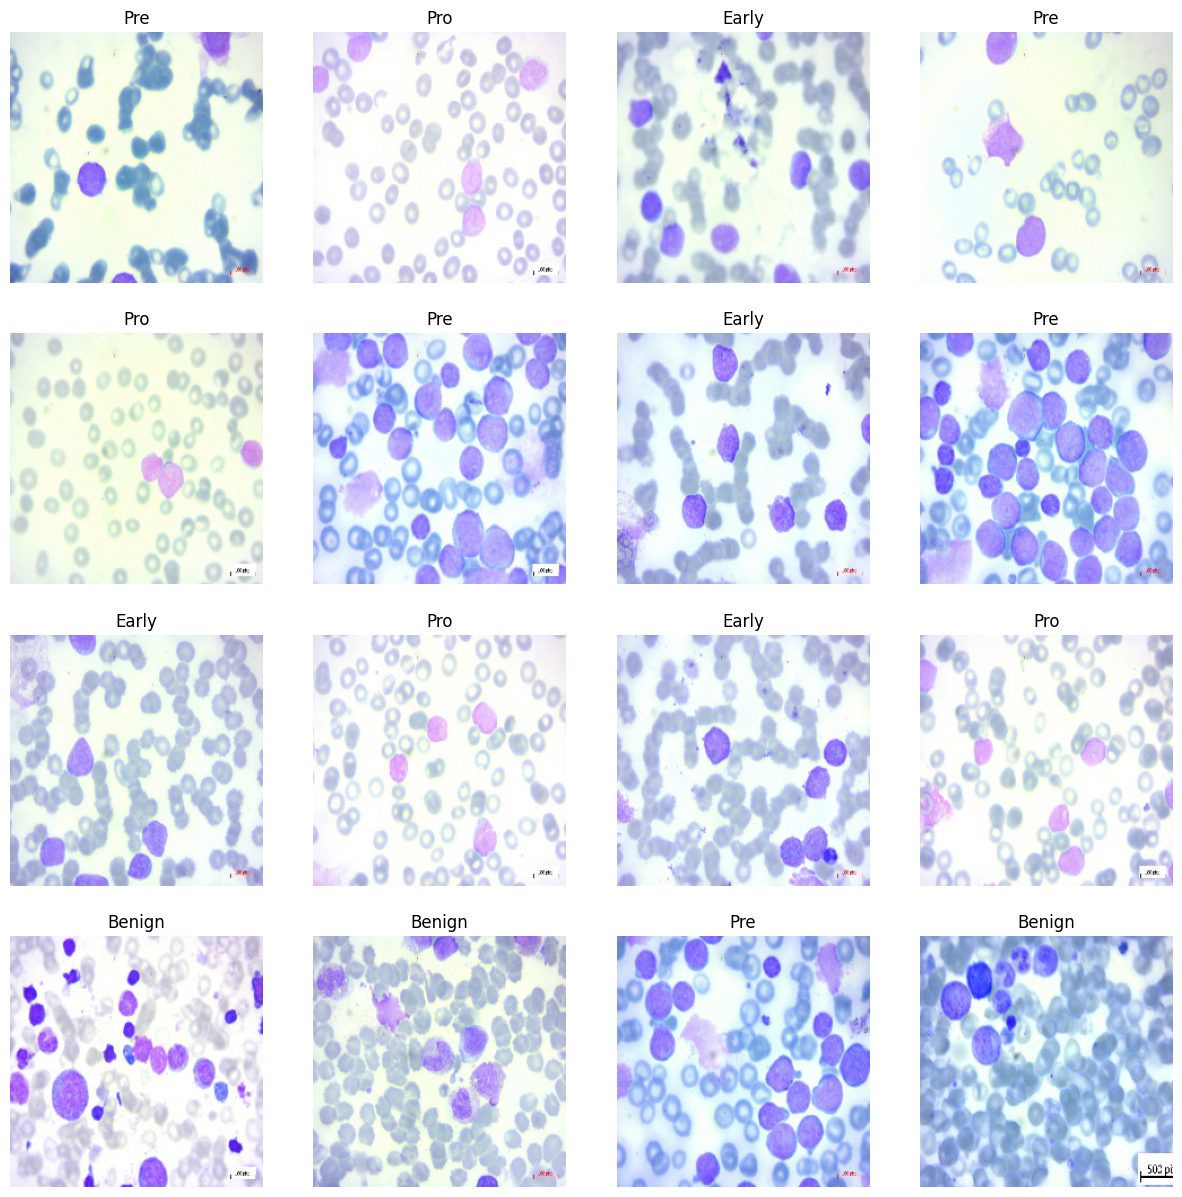

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_generator)

# Get the class names
class_names = list(train_generator.class_indices.keys())

# Create a function to display images
def plot_images(images, labels, class_names, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(images):
            # Display the image
            ax.imshow(images[i], aspect='auto')
            # Get the label index
            label_index = np.argmax(labels[i])
            # Display the label
            ax.set_title(class_names[label_index])
            ax.axis('off')
        else:
            ax.axis('off')

# Display the images and their labels
plot_images(images, labels, class_names)

In [12]:
loss = 'categorical_crossentropy' # Better performance than categorical_crossentropy
# optimizer = keras.optimizers.Adam
optimizer = Adamax

# Create learning rates for two phases of training 
learning_rates = 0.0001

# Setting the number of training epochs
training_epochs = 10

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'), # Use CategoricalAccuracy for one-hot encoded labels
      #keras.metrics.SparseCategoricalAccuracy(name='accuracy'), # Use SparseCategoricalAccuracy for integer labels
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'), 
      #keras.metrics.SpecificityAtSensitivity(0.5,name='SpecificityAtSensitivity'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=loss, optimizer=optimizer(learning_rates), metrics=metrics)






In [13]:
history = model.fit(
    train_generator,
    epochs=training_epochs,
    validation_data=val_generator,
    class_weight=class_weights_dict 
)

model.save('/content/drive/MyDrive/W281/Final_no_preprocess_model.h5')

Epoch 1/10
122/122 [==============================] - 306s 977ms/step - loss: 0.5272 - tp: 1602.0000 - fp: 278.0000 - tn: 5578.0000 - fn: 350.0000 - accuracy: 0.8340 - val_loss: 0.0642 - val_tp: 632.0000 - val_fp: 17.0000 - val_tn: 1939.0000 - val_fn: 20.0000 - val_accuracy: 0.9709
Epoch 2/10
122/122 [==============================] - 112s 915ms/step - loss: 0.1758 - tp: 1835.0000 - fp: 90.0000 - tn: 5766.0000 - fn: 117.0000 - accuracy: 0.9462 - val_loss: 0.0386 - val_tp: 642.0000 - val_fp: 10.0000 - val_tn: 1946.0000 - val_fn: 10.0000 - val_accuracy: 0.9847
Epoch 3/10
122/122 [==============================] - 111s 910ms/step - loss: 0.1052 - tp: 1874.0000 - fp: 60.0000 - tn: 5796.0000 - fn: 78.0000 - accuracy: 0.9647 - val_loss: 0.0220 - val_tp: 648.0000 - val_fp: 4.0000 - val_tn: 1952.0000 - val_fn: 4.0000 - val_accuracy: 0.9939
Epoch 4/10
122/122 [==============================] - 111s 912ms/step - loss: 0.0570 - tp: 1917.0000 - fp: 28.0000 - tn: 5828.0000 - fn: 35.0000 - accuracy:

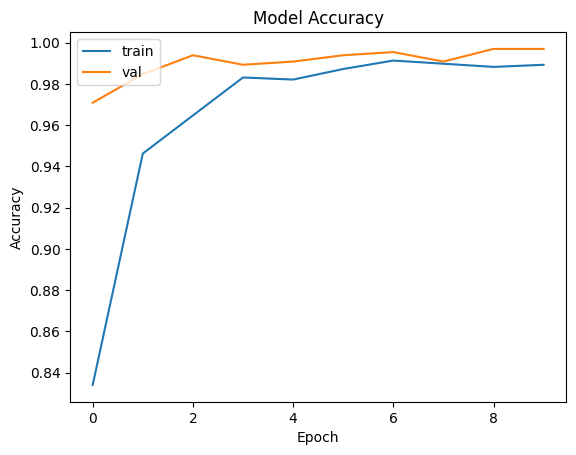

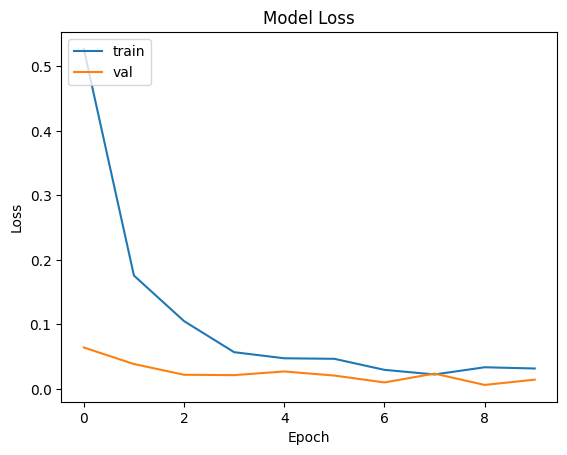

In [14]:

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Evaluate on test set
from sklearn.metrics import f1_score
datagen = ImageDataGenerator(rescale=1./255)

test_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/W281/Test_image",
    target_size=img_size,
    batch_size=16,
    class_mode='categorical',
    )
test_results = model.evaluate(test_data, verbose=2)
tp = test_results[1]
fp = test_results[2]
tn = test_results[3]
fn = test_results[4]
accuracy=test_results[5]



Found 652 images belonging to 4 classes.
41/41 - 9s - loss: 0.0770 - tp: 640.0000 - fp: 11.0000 - tn: 1945.0000 - fn: 12.0000 - accuracy: 0.9831 - 9s/epoch - 217ms/step


In [16]:
# For test_data
test_class_indices = test_data.class_indices
test_class_counts = {k: 0 for k in test_class_indices}

for label in test_data.labels:
    class_name = list(test_class_indices.keys())[list(test_class_indices.values()).index(label)]
    test_class_counts[class_name] += 1

print("Test class counts:", test_class_counts)


Test class counts: {'Benign': 101, 'Early': 197, 'Pre': 193, 'Pro': 161}


In [17]:


# Get the number of batches in the test_data
num_batches = len(test_data)

# Initialize an empty list to store images
images_list = []
labels_list= []

# Loop through the test_data generator
for i in range(num_batches):
    # Get a batch of images and their labels
    images_batch, labels_batch = next(test_data)
    
    # Append the images from this batch to the images_list
    images_list.append(images_batch)
    labels_list.append(labels_batch)

# Concatenate all the batches into a single numpy array
images_array = np.concatenate(images_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

print("Images array shape:", images_array.shape)

Images array shape: (652, 224, 224, 3)


In [18]:
y_predict = model.predict(images_array)
y_predict_classes=np.argmax(y_predict, axis=1)
y_true=np.argmax(labels_array, axis=1)
f1 = f1_score(y_true,y_predict_classes, average=None)
f1_average = f1_score(y_true,y_predict_classes, average='weighted')
print("F1 score: ", f1)
print("F1 score average: ", f1_average)

21/21 [==============================] - 17s 399ms/step
F1 score:  [0.95918367 0.97755611 0.99220779 0.99378882]
F1 score average:  0.9830555345590063


<Axes: >

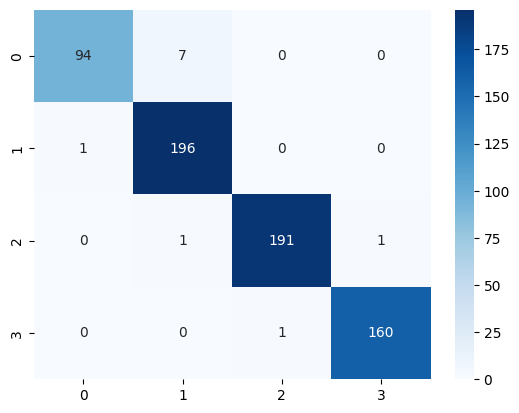

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_true, y_predict_classes)
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d")

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 117,751,972
Trainable params: 117,239,396
Non-t

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Load your fine-tuned model
model = tf.keras.models.load_model('/content/drive/MyDrive/W281/Final_no_preprocess_model.h5')


# Preprocess your input image
img_path = '/content/drive/MyDrive/W281/Test_image/Benign/WBC-Benign-010.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predictions and the index of the predicted class
preds = model.predict(x)
class_idx = np.argmax(preds[0])

# Access the EfficientNetV2-L layer and find the last convolutional layer
efficientnet_layer = model.get_layer('efficientnetv2-l')
last_conv_layer_name = 'top_conv'  # This is typically the last conv layer in EfficientNetV2-L

# Create a new model that outputs the last convolutional layer's output
last_conv_layer = efficientnet_layer.get_layer(last_conv_layer_name)
conv_model = tf.keras.Model(efficientnet_layer.inputs, last_conv_layer.output)

#conv_model.summary()
#model.summary()

with tf.GradientTape() as tape:
    inputs = tf.cast(x, tf.float32)
    tape.watch(inputs)
    conv_output = conv_model(inputs)
    preds = model(inputs)
    top_pred = preds[:, class_idx]

grads = tape.gradient(top_pred, conv_output)


#print("Gradients shape:", grads.shape)
print("Conv output shape:", conv_output.shape)

# Perform the weighted sum (Grad-CAM)
grads = tf.reduce_mean(grads, axis=(1, 2))
cam = tf.reduce_sum(tf.multiply(grads[..., None], conv_output), axis=-1)

# Normalize the heatmap
heatmap = np.maximum(cam.numpy()[0], 0)
heatmap /= np.max(heatmap)

# Resize the heatmap and overlay it on the input image
import cv2

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

cv2.imwrite('/content/drive/MyDrive/W281/grad_cam_image.jpg', superimposed_img)

1/1 [==============================] - 7s 7s/step
Conv output shape: (1, 7, 7, 1280)


ValueError: ignored

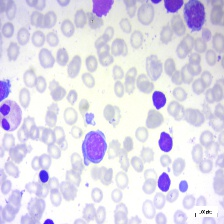

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
input_shape = (480,480,3)
model_builder = tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=input_shape, include_top=True)

img_size = (480, 480)
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

decode_predictions = tf.keras.applications.efficientnet_v2.decode_predictions

last_conv_layer_name = "top_conv"

# The local path to our target image
# The local path to our target image
img_path = "/content/drive/MyDrive/W281/Test_image/Benign/WBC-Benign-010.jpg"

# Load the image using OpenCV
img = cv2.imread(img_path)
img = cv2.resize(img, img_size)

display(Image(img_path))

In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
import numpy as np

def custom_decode_predictions(preds, class_labels, top=1):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_labels[i], pred[i]) for i in top_indices]
        results.append(result)
    return results




1/1 [==============================] - 0s 84ms/step
Predicted: [('n01930112', 'nematode', 0.27253523)]


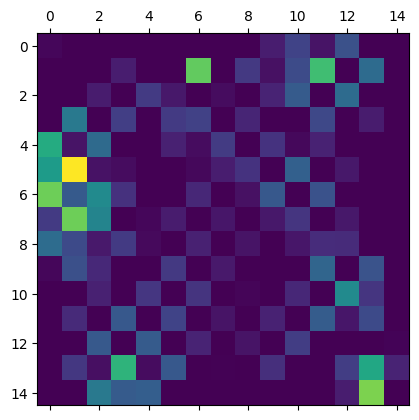

In [30]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")
model = model_builder
# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()



<ipython-input-31-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


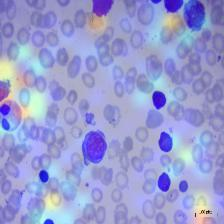

In [31]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

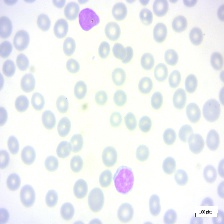

1/1 [==============================] - 0s 80ms/step
Predicted: [('n04209239', 'shower_curtain', 0.09927318), ('n09229709', 'bubble', 0.08560145)]


In [32]:
img_path = "/content/drive/MyDrive/W281/Test_image/Pro/WBC-Malignant-Pro-014.jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

<ipython-input-31-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


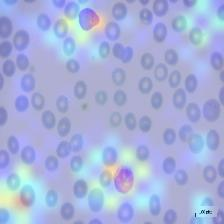

In [33]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

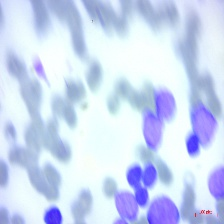

1/1 [==============================] - 0s 77ms/step
Predicted: [('n03920288', 'Petri_dish', 0.1170616), ('n01924916', 'flatworm', 0.037045524)]


<ipython-input-31-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


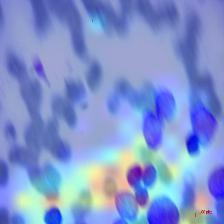

In [34]:
img_path = "/content/drive/MyDrive/W281/Original/Early/WBC-Malignant-Early-043.jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

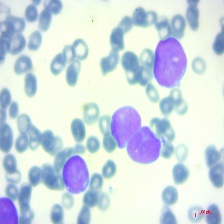

1/1 [==============================] - 0s 119ms/step
Predicted: [('n03920288', 'Petri_dish', 0.44037798), ('n01930112', 'nematode', 0.046184108)]


<ipython-input-31-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


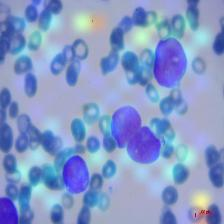

In [41]:
img_path = "/content/drive/MyDrive/W281/Original/Pre/WBC-Malignant-Pre-187.jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)